In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
import seaborn as sns
sns.set_theme(style='ticks')

from g2aero.Grassmann import *
from g2aero.perturbation import PGAspace, Dataset

plot_folder = os.path.join(os.getcwd(), 'plots_pga_sampling', )
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

In [2]:
def intersection_exist(blade):
    flag = []
    for i, shape in enumerate(blade):
        flag.append(PGAspace.intersection_exist(shape, i))
    return True in flag

In [3]:
airfoils = [ 'NACA64_A17', 
            'DU21_A17', 'DU25_A17', 'DU30_A17', 'DU35_A17', 'DU40_A17', 'DU00-W2-350', 'DU08-W-210',
            'FFA-W3-211',  'FFA-W3-241', 'FFA-W3-270blend', 'FFA-W3-301', 'FFA-W3-330blend', 'FFA-W3-360', 'SNL-FFA-W3-500', ]
cl = ['NACA', 'DU', 'DU', 'DU', 'DU', 'DU', 'DU', 'DU', 
      'FFA',  'FFA', 'FFA', 'FFA', 'FFA', 'FFA', 'FFA']
gap_size = [0.0, 0.003878, 0.004262, 0.00492, 0.00566, 0.00694,  0.01, 0.00278,
            0.00131, 0.00751, 0.01265, 0.0182, 0.024079999999999997, 0.01368, 0.020200000000000003]
gap = np.array([g for g in gap_size for i in range(1001)])
n_airfoils = len(airfoils)
classes = [c for c in cl for i in range(1001)]

In [4]:
pga_dict = np.load(os.path.join(os.getcwd(), 'PGA_space.npz'))
pga = PGAspace(pga_dict['Vh'], pga_dict['M_mean'], pga_dict['b_mean'], pga_dict['karcher_mean'])
M = np.load(os.path.join(os.getcwd(), 'M_b.npz'))['M']
b = np.load(os.path.join(os.getcwd(), 'M_b.npz'))['b']
t = np.load(os.path.join(os.getcwd(),  't.npz'))['t']
s2 = M[:, 1:, 1]

In [5]:
print('Varience', np.var(t, axis=0))
print('99%', np.quantile(t, 0.99, axis=0))
print('1%', np.quantile(t, 0.01, axis=0))

coord = np.hstack((t, M[:, 1:, 1], gap.reshape(-1, 1)))
r_min = np.abs(np.quantile(t, 0.00, axis=0))
r_max = np.abs(np.quantile(t, 1., axis=0))
radius = np.max(np.array([r_min, r_max]), axis=0).tolist()

Varience [0.00552266 0.00208956 0.0011414  0.00045235]
99% [0.1020655  0.07478516 0.07795528 0.04769375]
1% [-0.21252352 -0.14132889 -0.08287567 -0.05326685]


In [6]:
radius.append((np.max(s2[:-1001]) - np.min(s2[:-1001]))/2)
print(radius)
centers = [0, 0, 0, 0, (np.max(s2[:-1001]) + np.min(s2[:-1001]))/2]
print(centers)
centers = np.array(centers)
radius = np.array(radius)

[0.2547594372237038, 0.17834713217701248, 0.12117577168842089, 0.08640197583844275, 0.8345452183327882]
[0, 0, 0, 0, 1.809241305634829]


[1.34703289 1.05076676] [0.00131 0.00131]
[1.34703289 2.64378652] [0.00131 0.00694]
[2.13023251 2.64378652] [0.02408 0.00694]
[2.13023251 1.74616371] [0.02408 0.02408]
[1.55359315 1.74616371] [0.0182  0.02408]
[1.55359315 1.22418178] [0.0182  0.00751]
[1.08353647 1.05076676] [0.00278 0.00131]
[1.08353647 1.22418178] [0.00278 0.00751]
0.030534262350381973 -0.029237820827856302


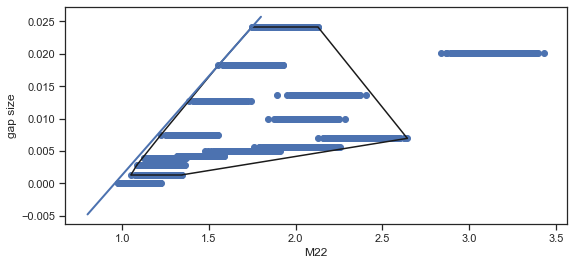

In [7]:
from scipy.spatial import ConvexHull
sg = np.hstack((t, s2, gap.reshape((-1, 1))))
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
ax.scatter(s2, gap)
ax.set_ylabel('gap size')
ax.set_xlabel('M22')

hull = ConvexHull(sg[1001:-1001, -2:])
for simplex in hull.simplices:
    ax.plot(sg[simplex+1001, -2], sg[simplex+1001, -1], 'k-')
    print(sg[simplex+1001, -2], sg[simplex+1001, -1])
x = [1.55359315, 1.74616371]
y = [0.0182, 0.02408]
m, l = np.polyfit(x, y, 1)
print(m, l)
ax.plot(np.linspace(0.8, 1.8, 100), m*np.linspace(0.8, 1.8, 100)+l, lw=2)

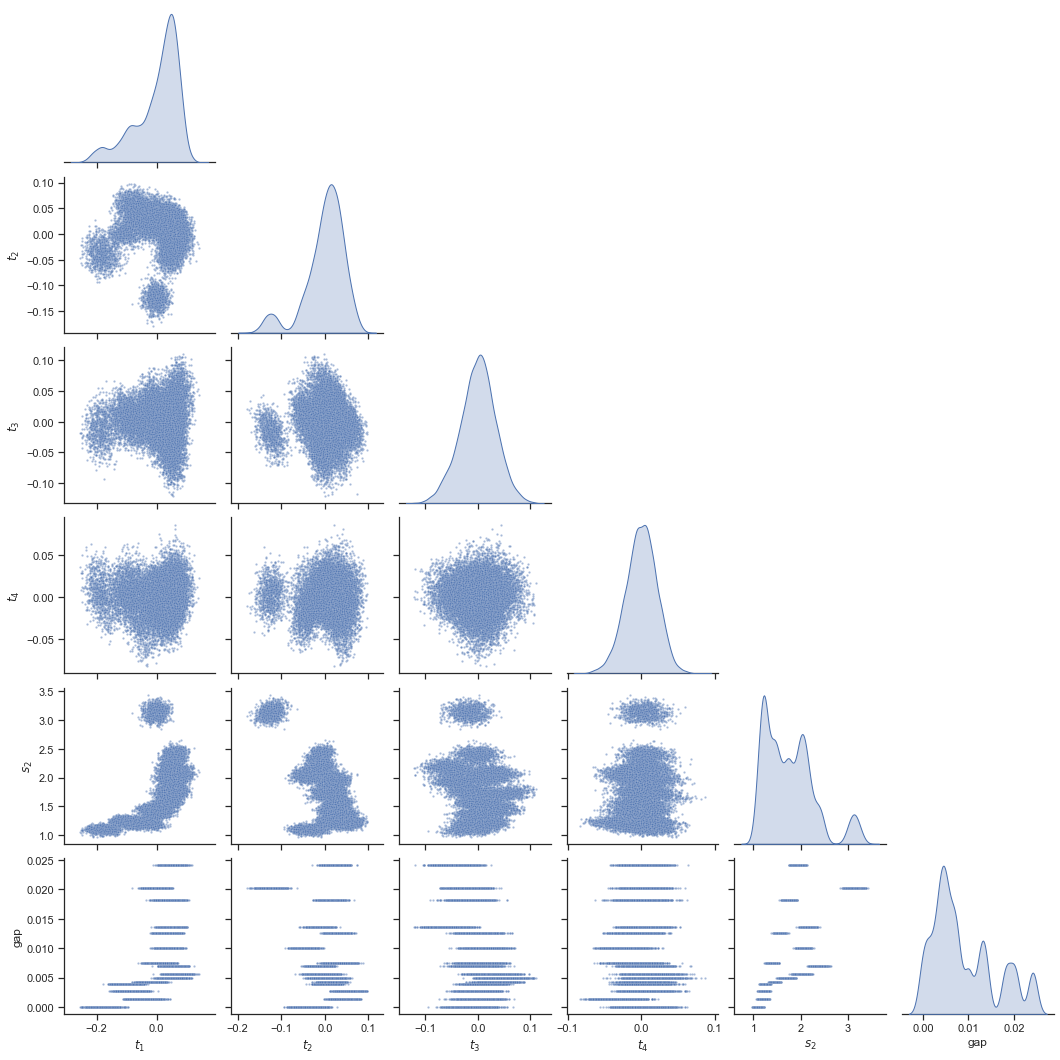

In [8]:
# build dataframe
df = pd.DataFrame(data=coord, columns=['$t_1$', '$t_2$', '$t_3$', '$t_4$', '$s_2$', 'gap'])
df.insert(5, "classes", classes)
sns_plot = sns.pairplot(df,
                        x_vars=['$t_1$', '$t_2$', '$t_3$', '$t_4$', '$s_2$', 'gap'],
                        y_vars=['$t_1$', '$t_2$', '$t_3$', '$t_4$', '$s_2$', 'gap'],
                        diag_kind='kde', palette="magma", corner=True, plot_kws=dict(alpha=.5, s=5))

sns_plot.savefig(os.path.join(plot_folder, 'scatter.png'))

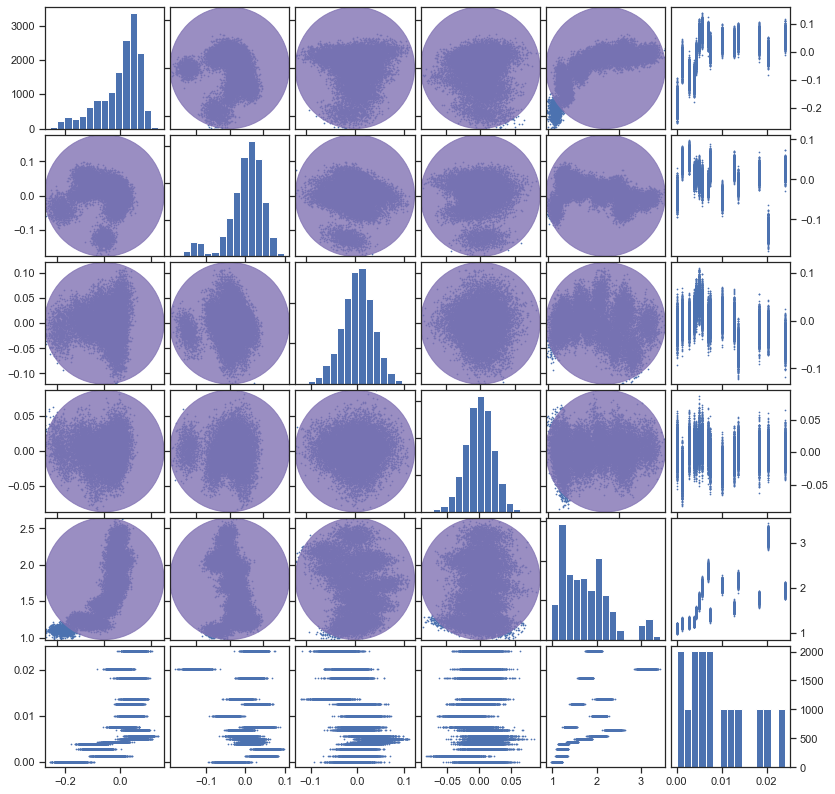

In [12]:
def matrixscatter_plot(matrix):
#     hull = ConvexHull(matrix)
    n = matrix.shape[1] 
    r = radius
    fig = plt.figure(figsize=(n*2+2, n*2))
    for i in range(n):
        for j in range(n):
            ax = plt.subplot2grid((n, n), (i, j))
            if i == j:
                ax.hist(matrix[:, j], bins=15)
            else:
                ax.scatter(matrix[:, j], matrix[:, i], s=0.5)
                if not (i==5 or j==5):
                    ell = Ellipse(xy=[centers[j], centers[i]], width=2*r[j], height=2*r[i], alpha=0.8, color='m')
                    ax.add_artist(ell)
                    ax.axis(xmin=axis_min[j], xmax=axis_max[j], ymin=axis_min[i], ymax=axis_max[i])

            if j != 0 and j != n-1:
                ax.yaxis.set_major_formatter(plt.NullFormatter())
            if j == n-1:
                ax.yaxis.tick_right()
                ax.yaxis.set_label_position("right")
            if i != n - 1:
                ax.xaxis.set_major_formatter(plt.NullFormatter())
                
    fig.subplots_adjust(left=0.05, right=0.79, wspace=0.05, hspace=0.05, bottom=0.1, top=0.98)
    
    fig.savefig(os.path.join(plot_folder, 't_scatter.png'))

axis_min = np.minimum(np.min(coord[:, :-1], axis=0), centers-radius)
axis_max = np.maximum(np.min(coord[:, :-1], axis=0), centers+radius)
matrixscatter_plot(coord)

(912, 401, 2)


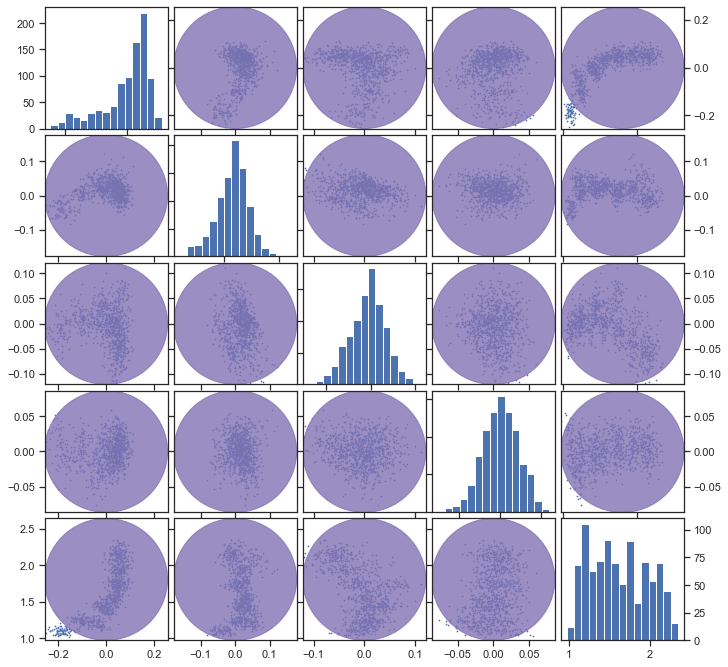

In [13]:
shapes_folder  = os.path.join(os.getcwd(), '../../ARPA-E_INTEGRATE/shape_data/dataset/', )
cfd_shapes = np.load(shapes_folder + 'cfd_shape_data.npy')
print(cfd_shapes.shape)
shapes_gr, M, b = landmark_affine_transform(cfd_shapes)
cfd_pga = pga.gr_shapes2PGA(shapes_gr)
cfd_pga_M = np.hstack((cfd_pga , M[:, 1:, 1]))

matrixscatter_plot(cfd_pga_M)

In [14]:
from g2aero.utils import position_airfoil, add_tailedge_gap

def sampl(n, centers, radius):
    phys_shapes = np.empty((1000, 401, 2))
    centers = np.array(centers)
    radius = np.array(radius)
    samples = np.empty((1000, 6))
    k = 0
    while k < n:
        c = np.random.uniform( centers - radius, centers + radius)
        if np.sum((c  - centers)**2/ radius ** 2) <= 1:
            g = np.random.uniform(0.002, np.max(gap))
            if g < (m*c[-1]+l):
                c = np.hstack((c, g))
                M = pga.M_mean.copy()
                M[1, 1] = c[4]
                shape = pga.PGA2shape(c[:4], M=M)
                shape = position_airfoil(shape)
                phys_shape = add_tailedge_gap(shape, c[5])
                
                if not PGAspace.intersection_exist(phys_shape, k):    
                    samples[k] = c
                    phys_shapes[k] = phys_shape
                    k+=1
    return samples, phys_shapes

(1000, 401, 2)


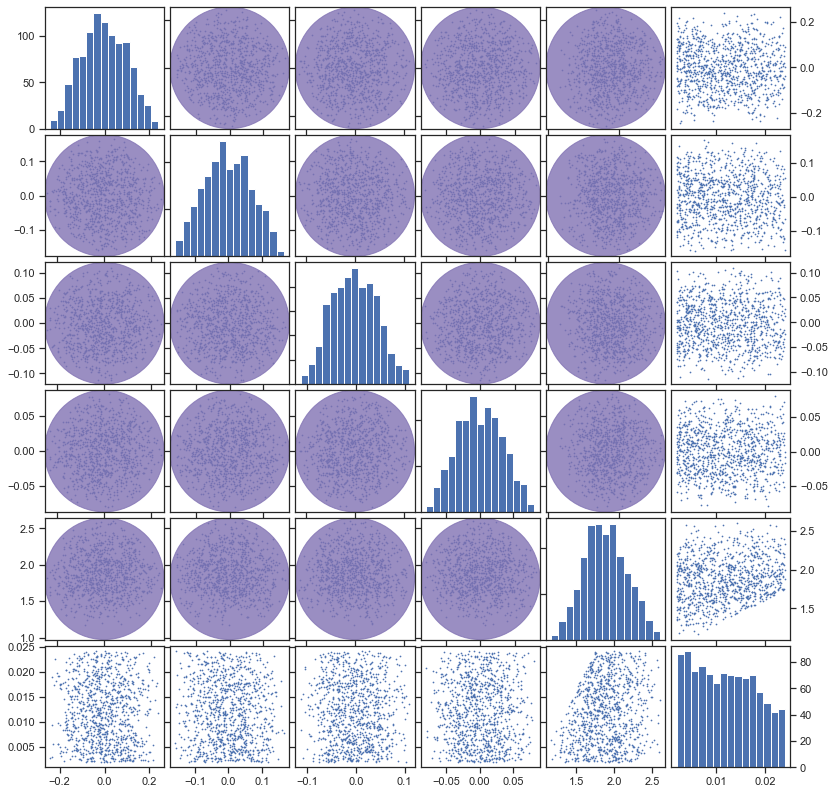

In [15]:
samples, phys_shapes = sampl(1000, centers, radius)
print(phys_shapes.shape)
matrixscatter_plot(samples)

In [ ]:
# %matplotlib notebook
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(6, 15))
s2_ind = np.argsort(samples[:, 4])
shapes_sort = phys_shapes[s2_ind]
for i in range(5):
    for j, xy in enumerate(shapes_sort[i*200:(i+1)*200]):
        ax[i].plot(xy[:, 0], xy[:, 1])
        ax[i].axis('equal')

#     ax.set_xlabel(r'$x$', fontsize=15)
#     ax.set_ylabel(r'$y$', fontsize=15)
fig.subplots_adjust(left=0.15, right=0.95,  bottom=0.12, top=0.98, hspace=0.03, wspace=0.02)
fig.savefig(os.path.join(plot_folder, f'airfoil_samples.pdf'))

In [ ]:
np.savez(os.path.join(plot_folder, 'airfoil_samples.npz'), 
     shapes=phys_shapes, coef=samples, M=pga.M_mean, b=pga.b_mean, Vh=pga.Vh)